# Value Estimation -- quadrature vs uniform

In [2]:
import math
from importlib import reload

import gc
import matplotlib.pyplot as plt
import pickle
import numpy as np

from tqdm.notebook import tqdm

from adaptive_time import plot_utils
from adaptive_time import utils
from adaptive_time import run_lib
from adaptive_time.environments import cartpole2
from adaptive_time import value_est
from adaptive_time.value_est import approx_integrators

from pprint import pprint

approx_integrators = reload(approx_integrators)
run_lib = reload(run_lib)
cartpole2 = reload(cartpole2)
value_est = reload(value_est)
plot_utils = reload(plot_utils)
utils = reload(utils)

/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment CartPole-OURS-v2 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Make this notebook configurable so we can quickly generate plots for multiple variants.

In [3]:
utils.set_directory_in_project()

Changed working directory to /Users/szepi1991/Code/adaptive_time


'/Users/szepi1991/Code/adaptive_time'

In [53]:
data_to_load = "classic_control_data/cartpole2_rew_discrete_termTrue.pkl"
# data_to_load = "classic_control_data/mountain_car.pkl"

filename = data_to_load.split("/")[-1]
filename = filename.split(".")[0]


In [56]:
results_path = "results/classic"

In [14]:
with open(data_to_load, "rb") as f:
    all_traj_data = pickle.load(f)
total_rewards, reward_sequences, traj_lengths = all_traj_data[:3]

print("Loaded data from", data_to_load)

del all_traj_data   # Clear up memory.

print("total_rewards for each traj:", total_rewards)
if hasattr(reward_sequences, "shape"):
    print("all rewards shape if array:", reward_sequences.shape)
num_trajs = len(total_rewards)

Loaded data from classic_control_data/mountain_car.pkl
total_rewards for each traj: [-111.21000000001999, -109.62000000001917, -109.74000000001924, -111.69000000002023, -120.98000000002499, -111.91000000002035, -117.75000000002333, -120.26000000002462, -111.41000000002009, -200.00999999996307, -112.28000000002054, -109.95000000001934, -112.24000000002052, -109.42000000001907, -110.00000000001937, -200.00999999996307, -112.0100000000204, -111.99000000002039, -118.6700000000238, -111.41000000002009, -111.00000000001988, -200.00999999996307, -122.06000000002554, -118.40000000002367, -112.24000000002052, -112.36000000002058, -112.03000000002041, -111.6200000000202, -112.25000000002052, -112.2200000000205, -200.00999999996307, -112.4100000000206, -113.41000000002111, -110.67000000001971, -110.27000000001951, -109.35000000001904, -110.99000000001988, -110.04000000001939, -110.15000000001945, -111.95000000002037, -118.05000000002349, -112.26000000002053, -111.97000000002038, -111.460000000020

(array([ 9.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 22., 69.]),
 array([-200.01 , -190.872, -181.734, -172.596, -163.458, -154.32 ,
        -145.182, -136.044, -126.906, -117.768, -108.63 ]),
 <BarContainer object of 10 artists>)

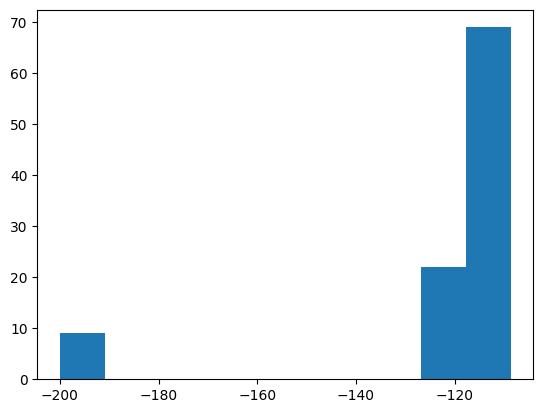

In [15]:
plt.hist(total_rewards)

False


In [18]:
NUM_RUNS = 100
SAMPLE_BUDGET = 1_000_000

BUDGET_INTERP_STEP = 1_000


## Data setup 2: the weights across initial states


In [16]:
seed = 43
run_lib.reset_randomness(seed, env=None)

weights = np.ones((num_trajs,)) / num_trajs
# weights = np.random.random((num_trajs,))
# weights /= np.sum(weights)

print("weights:", weights)
print("sum:", np.sum(weights))

weights: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
sum: 0.9999999999999999


## Learning

Constants

In [19]:
print("num_runs:", NUM_RUNS)
print("sample_budget:", SAMPLE_BUDGET)

num_runs: 100
sample_budget: 1000000


### Ground truth value

In [20]:
true_value = total_rewards @ weights
print("true value:", true_value)

true value: -121.1811000000159


### Learn from samples; with diff samplers

In [22]:
unif_sampler_params = np.power(2, np.arange(0, 11, 2))
quad_sampler_params = np.concatenate(
    (np.array([0]), np.power(2, np.arange(-3.0, 10, 2))), axis=0
)

print('unif_sampler_params:', unif_sampler_params)
print('quad_sampler_params:', quad_sampler_params)


unif_sampler_params: [   1    4   16   64  256 1024]
quad_sampler_params: [0.00e+00 1.25e-01 5.00e-01 2.00e+00 8.00e+00 3.20e+01 1.28e+02 5.12e+02]


In [23]:
samplers_tried = {
    f'q{p}': approx_integrators.AdaptiveQuadratureIntegrator(tolerance=p)
    for p in quad_sampler_params
}
samplers_tried.update({
    f'u{p}': approx_integrators.UniformlySpacedIntegrator(p)
    for p in unif_sampler_params
})


In [24]:
def name_to_param(name):
    num = float(name[1:])
    if name[0] == 'q':
        return num
    else:
        return int(num)

def name_to_type(name):
    return name[0]

def param_to_name(sampler_char, param):
    return f"{sampler_char}{param}"

Since everything other than the start state is deterministic, we can just calculate the approximate integrals for each trajectory with each integrator and store these.

In [25]:
approx_integrals = {}
num_pivots = {}

for sampler_name, sampler in tqdm(samplers_tried.items()):
    print("sampler_name:", sampler_name)
    approx_integrals[sampler_name] = []
    num_pivots[sampler_name] = []
    for idx, reward_seq in enumerate(reward_sequences):
        integral, all_pivots = sampler.integrate(reward_seq)
        approx_integrals[sampler_name].append(integral)
        num_pivots[sampler_name].append(len(all_pivots))
    approx_integrals[sampler_name] = np.array(approx_integrals[sampler_name])
    num_pivots[sampler_name] = np.array(num_pivots[sampler_name])



  0%|          | 0/14 [00:00<?, ?it/s]

sampler_name: q0.0
sampler_name: q0.125
sampler_name: q0.5
sampler_name: q2.0
sampler_name: q8.0
sampler_name: q32.0
sampler_name: q128.0
sampler_name: q512.0
sampler_name: u1
sampler_name: u4
sampler_name: u16
sampler_name: u64
sampler_name: u256
sampler_name: u1024


In [26]:
traj_id = 0

print("Sample data for trajectory 0:")
print("* True return:", total_rewards[traj_id])
print("* Approx integrals:")
{k: v[traj_id] for k, v in approx_integrals.items()}


Sample data for trajectory 0:
* True return: -111.21000000001999
* Approx integrals:


{'q0.0': -111.21,
 'q0.125': -111.21,
 'q0.5': -111.21,
 'q2.0': -111.21,
 'q8.0': -111.21,
 'q32.0': -111.21,
 'q128.0': -111.21,
 'q512.0': -111.21,
 'u1': -111.21000000001999,
 'u4': -111.21000000000619,
 'u16': -111.20999999999835,
 'u64': -111.2100000000001,
 'u256': -111.21000000000006,
 'u1024': -111.21}

In [27]:
traj_id = 0

{k: v[traj_id] for k, v in num_pivots.items()}


{'q0.0': 17,
 'q0.125': 3,
 'q0.5': 3,
 'q2.0': 3,
 'q8.0': 3,
 'q32.0': 3,
 'q128.0': 3,
 'q512.0': 3,
 'u1': 11121,
 'u4': 2781,
 'u16': 696,
 'u64': 175,
 'u256': 45,
 'u1024': 12}

Now we just keep sampling the start state and integrate accordingly.

In [28]:
gc.collect()

513

In [29]:

seed = 43

samplers_to_learn_with = samplers_tried
# samplers_to_learn_with = {
#     'u1024': samplers_tried['u1024'],
# }

data = value_est.simulate_learning(
        seed, samplers_to_learn_with, SAMPLE_BUDGET, num_runs=NUM_RUNS,
        start_state_weights=weights,
        approx_integrals=approx_integrals, num_pivots=num_pivots,
        tqdm=tqdm)


gc.collect()
# with open(procesed_data_file, "wb") as f:
#     pickle.dump(data, f)


  0%|          | 0/14 [00:00<?, ?it/s]

sampler_name: q0.0


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: q0.125


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: q0.5


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: q2.0


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: q8.0


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: q32.0


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: q128.0


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: q512.0


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: u1


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: u4


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: u16


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: u64


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: u256


  0%|          | 0/100 [00:00<?, ?it/s]

sampler_name: u1024


  0%|          | 0/100 [00:00<?, ?it/s]

103

In [30]:
list(data.values())[0][0].keys()

dict_keys(['running_v_estimate', 'total_pivots'])

In [31]:
# # Verify final means.
# for sampler_name, all_runs_data in data.items():
#     for run_idx, run_data in enumerate(all_runs_data):
#         mean_of_indiv = np.mean(run_data["values_of_trajs"])
#         mean_updated = run_data["running_v_estimate"][-1]
#         if run_idx == 0:
#             print("mean_total:", mean_of_indiv, "mean_updated:", mean_updated)
#         if abs(mean_of_indiv - mean_updated) > 0.01:
#             assert False, (
#                 f"Means don't match for {sampler_name}, run {run_idx}: "
#                 f"{mean_of_indiv} vs {mean_updated}")


In [32]:
estimates_across_runs = np.array([ data["u256"][i]["running_v_estimate"][-1000] for i in range(NUM_RUNS) ])
estimates_across_runs

array([-121.08891021, -121.08596711, -121.09568378, -121.2956758 ,
       -121.10743356, -121.1317422 , -121.13651115, -121.15172503,
       -121.3735437 , -121.12983727, -121.27299421, -121.15325461,
       -121.22240654, -121.28837678, -121.1613112 , -121.13878597,
       -121.15624317, -121.20615519, -121.13048646, -121.25834386,
       -121.15606782, -121.20000768, -121.20088312, -121.2286288 ,
       -121.19412713, -121.23027626, -121.15242472, -121.10730538,
       -121.26135362, -121.13971445, -121.2483788 , -121.13740498,
       -121.19123807, -121.13933203, -121.27716861, -121.19162736,
       -121.19251391, -121.19203745, -121.29544055, -121.16875789,
       -121.28711023, -121.25944102, -121.23279694, -121.14160433,
       -121.12710346, -121.25114221, -121.07140191, -121.32048121,
       -121.10859234, -121.21759013, -121.29898425, -121.17714003,
       -121.2653752 , -121.28349057, -121.0728929 , -121.24599186,
       -121.05539752, -121.09866213, -121.28157574, -121.28606

In [34]:
gc.collect()

_values_data = plot_utils.process_across_runs(
        data, "total_pivots", "running_v_estimate", right=np.nan, interp_step=BUDGET_INTERP_STEP, tqdm=tqdm)

gc.collect()

_means = {
    k: np.abs(val - true_value)
    for k, val in _values_data.means.items()
}
error_data = _values_data._replace(means=_means)

error_y_label = "$|\hat{V}(S_0) - v_\pi(S_0)|$"

interpolating


  0%|          | 0/14 [00:00<?, ?it/s]

finding means and stderrs


  0%|          | 0/14 [00:00<?, ?it/s]

/Users/szepi1991/Code/adaptive_time/code/adaptive_time/plot_utils.py:70: RuntimeWarning: Mean of empty slice
  all_y_means[name] = np.nanmean(res, axis=0)
/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## Plots

In [58]:
title = filename

utils.set_directory_in_project(results_path)

Changed working directory to /Users/szepi1991/Code/adaptive_time/results/classic


'/Users/szepi1991/Code/adaptive_time/results/classic'


Method: uniform


  0%|          | 0/4 [00:00<?, ?it/s]


Budget:  1000
xs [1, 4, 16, 64, 256, 1024]
y_means: [3.5645     1.2689     1.67819121 0.02527789 0.34506603 0.46887721]
y_stderrs: [1.92685195 2.74707696 2.60460241 1.19468939 0.55952847 0.27095526]

Budget:  10000
xs [1, 4, 16, 64, 256, 1024]
y_means: [3.5645     0.53193186 0.1797114  0.48767982 0.05785252 0.14172169]
y_stderrs: [1.92685195 1.42014809 0.73495551 0.31994923 0.18003525 0.08645965]

Budget:  100000
xs [1, 4, 16, 64, 256, 1024]
y_means: [0.81825244 0.00236217 0.22280109 0.11327525 0.01947265 0.01923303]
y_stderrs: [0.95941078 0.44107162 0.19294436 0.09978799 0.05849046 0.02701848]

Budget:  1000000
xs [1, 4, 16, 64, 256, 1024]
y_means: [0.37357285 0.08386562 0.04797416 0.03075641 0.00731054 0.01289437]
y_stderrs: [0.2561973  0.12148921 0.06448242 0.03427554 0.01786172 0.00890384]

Method: quadrature


  0%|          | 0/4 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Budget:  1000
xs [0.0, 0.125, 0.5, 2.0, 8.0, 32.0, 128.0, 512.0]
y_means: [0.40168673 0.02782375 0.03435108 0.07416594 0.11266941 0.15459866
 0.03078612 0.08620517]
y_stderrs: [0.2757889  0.11634389 0.1392743  0.14804369 0.11507349 0.12753114
 0.12026188 0.1529617 ]

Budget:  10000
xs [0.0, 0.125, 0.5, 2.0, 8.0, 32.0, 128.0, 512.0]
y_means: [0.01923189 0.04350101 0.01923669 0.05117471 0.05452178 0.07379472
 0.04540092 0.03597236]
y_stderrs: [0.06360535 0.03974953 0.04360384 0.04999002 0.04182553 0.0410033
 0.04771544 0.0394493 ]

Budget:  100000
xs [0.0, 0.125, 0.5, 2.0, 8.0, 32.0, 128.0, 512.0]
y_means: [0.00373976 0.00711831 0.01484439 0.00793263 0.01205382 0.01847902
 0.00622718 0.00066554]
y_stderrs: [0.01953203 0.01502364 0.01456084 0.01375149 0.01244138 0.01240323
 0.01405234 0.01220733]

Budget:  1000000
xs [0.0, 0.125, 0.5, 2.0, 8.0, 32.0, 128.0, 512.0]
y_means: [0.0044474  0.00259382 0.00232127 0.00258536 0.00193315 0.00302001
 0.00424977 0.00776508]
y_stderrs: [0.00674321 0.

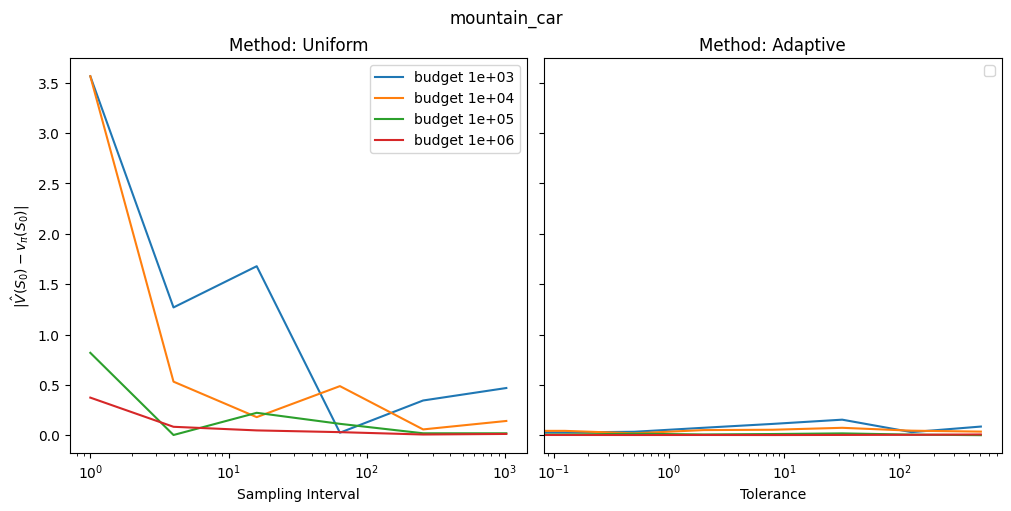

In [59]:


# These must be multiples of BUDGET_INTERP_STEP (usually 1000).
budgets_to_check = np.power(10, np.arange(3, 7, 1))
if SAMPLE_BUDGET >= 2_000_000:
    budgets_to_check *= 2


# budgets_to_check = np.power(10, np.arange(2, 7, 1))

# ax = plot_utils.default_plot_mean_from_proc_data(
#     error_data, "Number of Samples", error_y_label,
#     title=title, show=False, key_filter=lambda x: x in good,
#     add_stderr=True)

fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(10, 5), layout="constrained", sharey=True)

# axes[0] will get the uniform results, axes[1] the quadrature results.

# Gather the data for the points on the x-axis.
all_methods = error_data.means.keys()
unif_methods = {
    k: name_to_param(k) for k in all_methods if name_to_type(k) == "u"}
quad_methods = {
    k: name_to_param(k) for k in all_methods if name_to_type(k) == "q"}

unif_xs = sorted(unif_methods.values())
quad_xs = sorted(quad_methods.values())

for ax_idx, ax, xs, method_char in zip(range(2), axes, (unif_xs, quad_xs), ("u", "q")):
    print()
    print("Method:", "uniform" if method_char == "u" else "quadrature")
    for budget_for_curve in tqdm(budgets_to_check):
        print()
        print("Budget: ", budget_for_curve)
        budget_idx = int(budget_for_curve / BUDGET_INTERP_STEP)
        y_means = []
        y_stderrs = []
        try:
            for x in xs:
                y_means.append(error_data.means[param_to_name(method_char, x)][budget_idx])
                y_stderrs.append(error_data.stderrs[param_to_name(method_char, x)][budget_idx])
                # y_means.append(np.nanmean(env_result[x][:, budget_idx]))
                # y_stderrs.append(np.nanstd(env_result[x][:, budget_idx]) / np.sqrt(num_seeds))
            # y_means = np.log2(np.array(y_means))
            # y_stderrs = np.log2(np.array(y_stderrs))
                
            y_means = np.array(y_means)
            y_stderrs = np.array(y_stderrs)

            ax.plot(
                xs,
                y_means,
                label="budget {:.0e}".format(budget_for_curve) if ax_idx == 0 else ""
            )
            # ax.fill_between(
            #     xs,
            #     (y_means - y_stderrs),
            #     (y_means + y_stderrs),
            #     alpha=0.1
            # )

            print("xs", xs)
            print("y_means:", y_means)
            print("y_stderrs:", y_stderrs)
        except IndexError:
            pass

    if method_char == "u":
        ax.set_ylabel(error_y_label)
        ax.set_xlabel("Sampling Interval")
        ax.set_title("Method: Uniform")
    else:
        ax.set_xlabel("Tolerance")
        ax.set_title("Method: Adaptive")

    ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.legend()

fig.suptitle(title)
plt.legend()

plt.savefig(f'{filename}_u_shaped.png')

# def name_to_param(name):
#     return int(name[1:])

# def name_to_type(name):
#     return name[0]

# def param_to_name(param, sampler_char):
#     return f"{sampler_char}{param}"



# THE END

In [ ]:
assert False

## Plots: Error vs Samples [commented out]

In [39]:
plot_space = SAMPLE_BUDGET / 20.


#### Uniforms

In [40]:
# ax = plot_utils.default_plot_mean_from_proc_data(
#     error_data, "Number of Samples", error_y_label,
#     title=title, show=False, key_filter=lambda x: "u" in x,
#     add_stderr=True)

# ax.set_xlim(-plot_space, SAMPLE_BUDGET + plot_space)
# plt.savefig('unif_lin.png')



In [41]:
# ax = plot_utils.default_plot_mean_from_proc_data(
#     error_data, "Number of Samples", error_y_label,
#     title=title, show=False, key_filter=lambda x: "u" in x,
#     add_stderr=True)

# ax.set_xlim(-plot_space, SAMPLE_BUDGET + plot_space)
# ax.set_ylim(-0.001, 0.005)

# plt.savefig('unif_lin_zoom.png')



In [42]:
# ax = plot_utils.default_plot_mean_from_proc_data(
#     error_data, "Number of Samples", error_y_label,
#     title=title, show=False, key_filter=lambda x: "u" in x,
#     add_stderr=True)

# ax.set_yscale('log')
# ax.set_xscale('log')

# ax.set_xlim(-plot_space, SAMPLE_BUDGET + plot_space)

# plt.savefig('unif_loglog.png')



In [43]:
# ax = plot_utils.default_plot_mean_from_proc_data(
#     error_data, "Number of Samples", error_y_label,
#     title=title, show=False, key_filter=lambda x: "u" in x,
#     add_stderr=True)

# ax.set_yscale('log')
# # ax.set_xscale('log')
# ax.set_xlim(-plot_space, SAMPLE_BUDGET + plot_space)

# plt.savefig('unif_ylog.png')



In [44]:

# ax = plot_utils.default_plot_mean_from_proc_data(
#     error_data, "Number of Samples", error_y_label,
#     title=title, show=False, key_filter=lambda x: "q" in x,
#     add_stderr=True)

# ax.set_ylim(-1, 15)
# # ax.set_yscale('log')
# ax.set_xlim(-plot_space, SAMPLE_BUDGET + plot_space)


# plt.savefig('quad_lin_zoom.png')

# plt.show()



In [45]:

# ax = plot_utils.default_plot_mean_from_proc_data(
#     error_data, "Number of Samples", error_y_label,
#     title=title, show=False, key_filter=lambda x: "q" in x,
#     add_stderr=True)

# # ax.set_ylim(-2, 15)
# ax.set_yscale('log')
# ax.set_xlim(-plot_space, SAMPLE_BUDGET + plot_space)


# plt.savefig('quad_ylog.png')

# plt.show()



In [46]:

# ax = plot_utils.default_plot_mean_from_proc_data(
#     error_data, "Number of Samples", error_y_label,
#     title=title, show=False, key_filter=lambda x: "q" in x,
#     add_stderr=True)

# ax.set_yscale('log')
# ax.set_xscale('log')
# # ax.set_xlim(-plot_space, SAMPLE_BUDGET + plot_space)

# plt.savefig('quad_loglog.png')

# plt.show()



In [47]:
# good = ["u1", "u50", "u500", "q0", "q1", "q100"]

# ax = plot_utils.default_plot_mean_from_proc_data(
#     error_data, "Number of Samples", error_y_label,
#     title=title, show=False, key_filter=lambda x: x in good,
#     add_stderr=True)

# # ax.set_ylim(-2, 40)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(-plot_space, SAMPLE_BUDGET + plot_space)


# plt.savefig('select_loglog.png')

# plt.show()



## Error vs Param (Tolerance/Interval) Plots

In [48]:
# assert False

In [49]:
error_data.means.keys()

dict_keys(['q0.0', 'q0.125', 'q0.5', 'q2.0', 'q8.0', 'q32.0', 'q128.0', 'q512.0', 'u1', 'u4', 'u16', 'u64', 'u256', 'u1024'])


Method: uniform


  0%|          | 0/4 [00:00<?, ?it/s]


Budget:  1000
xs [1, 4, 16, 64, 256, 1024]
y_means: [3.5645     1.2689     1.67819121 0.02527789 0.34506603 0.46887721]
y_stderrs: [1.92685195 2.74707696 2.60460241 1.19468939 0.55952847 0.27095526]

Budget:  10000
xs [1, 4, 16, 64, 256, 1024]
y_means: [3.5645     0.53193186 0.1797114  0.48767982 0.05785252 0.14172169]
y_stderrs: [1.92685195 1.42014809 0.73495551 0.31994923 0.18003525 0.08645965]

Budget:  100000
xs [1, 4, 16, 64, 256, 1024]
y_means: [0.81825244 0.00236217 0.22280109 0.11327525 0.01947265 0.01923303]
y_stderrs: [0.95941078 0.44107162 0.19294436 0.09978799 0.05849046 0.02701848]

Budget:  1000000
xs [1, 4, 16, 64, 256, 1024]
y_means: [0.37357285 0.08386562 0.04797416 0.03075641 0.00731054 0.01289437]
y_stderrs: [0.2561973  0.12148921 0.06448242 0.03427554 0.01786172 0.00890384]

Method: quadrature


  0%|          | 0/4 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Budget:  1000
xs [0.0, 0.125, 0.5, 2.0, 8.0, 32.0, 128.0, 512.0]
y_means: [0.40168673 0.02782375 0.03435108 0.07416594 0.11266941 0.15459866
 0.03078612 0.08620517]
y_stderrs: [0.2757889  0.11634389 0.1392743  0.14804369 0.11507349 0.12753114
 0.12026188 0.1529617 ]

Budget:  10000
xs [0.0, 0.125, 0.5, 2.0, 8.0, 32.0, 128.0, 512.0]
y_means: [0.01923189 0.04350101 0.01923669 0.05117471 0.05452178 0.07379472
 0.04540092 0.03597236]
y_stderrs: [0.06360535 0.03974953 0.04360384 0.04999002 0.04182553 0.0410033
 0.04771544 0.0394493 ]

Budget:  100000
xs [0.0, 0.125, 0.5, 2.0, 8.0, 32.0, 128.0, 512.0]
y_means: [0.00373976 0.00711831 0.01484439 0.00793263 0.01205382 0.01847902
 0.00622718 0.00066554]
y_stderrs: [0.01953203 0.01502364 0.01456084 0.01375149 0.01244138 0.01240323
 0.01405234 0.01220733]

Budget:  1000000
xs [0.0, 0.125, 0.5, 2.0, 8.0, 32.0, 128.0, 512.0]
y_means: [0.0044474  0.00259382 0.00232127 0.00258536 0.00193315 0.00302001
 0.00424977 0.00776508]
y_stderrs: [0.00674321 0.

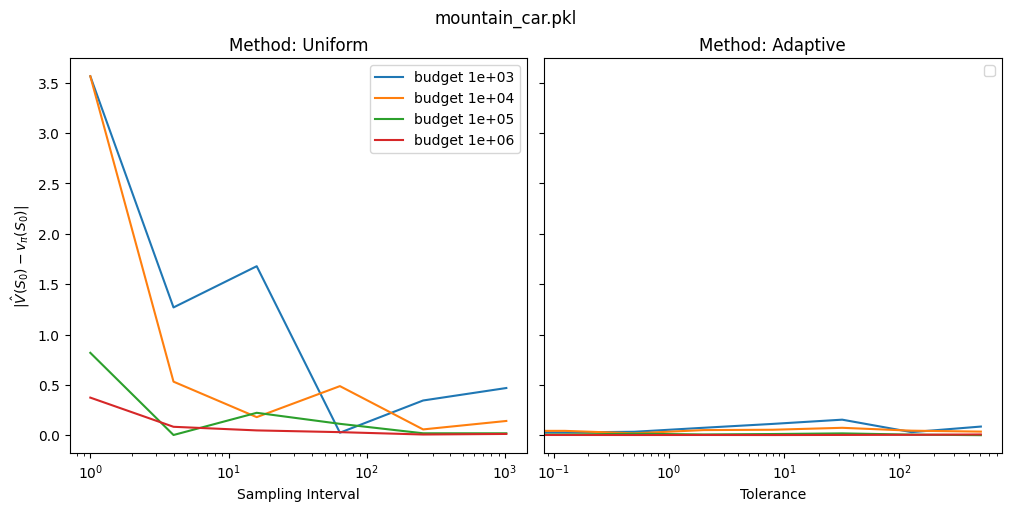

In [51]:


# if prefix == "uniform":
#     fig, axes = plt.subplots(nrows=len(est_results) // ncols, ncols=ncols, figsize=(15, 8), layout="constrained")

#     print(s_to_plot)
#     sorted_spacing = sorted(int(key[1:]) for key in list(s_to_plot))
#     sorted_keys = ["u{}".format(item) for item in sorted_spacing]
#     # budgets_to_check = 1e5 * np.arange(1, 10, 2)


#     budgets_to_check = budgets_to_check_per_env[env_name]
#     for budget_to_check in tqdm(budgets_to_check):
#         idx = int(budget_to_check)
#         y_means = []
#         y_stderrs = []
#         for s in sorted_keys:
#             y_means.append(np.nanmean(env_result[s][:, idx]))
#             y_stderrs.append(np.nanstd(env_result[s][:, idx]) / np.sqrt(num_seeds))
#         # y_means = np.log2(np.array(y_means))
#         # y_stderrs = np.log2(np.array(y_stderrs))
            
#         y_means = np.array(y_means)
#         y_stderrs = np.array(y_stderrs)

#         ax.plot(
#             sorted_spacing,
#             y_means,
#             label="{:.0e}".format(idx) if env_i == 0 else ""
#         )
#         ax.fill_between(
#             sorted_spacing,
#             (y_means - y_stderrs),
#             (y_means + y_stderrs),
#             alpha=0.1
#         )
#         ax.set_title("Env: {}".format(env_name))

#     fig.supylabel("Error in value estimate")
#     fig.supxlabel("Uniform Discretization")
#     fig.legend()
#     plt.show()




# Testing Random Things

In [52]:
(math.pi + 3.5) % (2*math.pi) - math.pi

-2.7831853071795862